# <b>Fondamenti di Analisi Dati</b> - a.a. 2020/2021

# 15.1 Alberi Decisionali su 2 variabili
 
Un albero decisionale permette di affrontare un problema di classificazione definendo una serie di regole che vengono applicate in maniera gerarchica sulle proprietà dei dati in analisi.

Vediamo un esempio il dataset delle iris di Fisher:

In [1]:
from statsmodels.datasets import get_rdataset
fisher = get_rdataset('iris')

C:\Users\visig\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


Suddividiamo il dataset in training e test set:

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

#impostiamo un seed per ripetitibilità
np.random.seed(1346)

fisher_training, fisher_test = train_test_split(fisher.data,test_size=0.15)
print("Numero di campioni di training",len(fisher_training))
print("Numero di campioni di test",len(fisher_test))

Numero di campioni di training 127
Numero di campioni di test 23


Iniziamo costruendo un albero decisionale su dati bidimensionali. Per farlo, scegliamo solo due features e costruiamo un dataset con tre colonne "X", "Y", "C":

In [3]:
import pandas as pd
def format_data(data):
    #costruiamo un dataframe vuoto
    df = pd.DataFrame()
    #inserieamo le prime due feature e chiamiamole X e Y
    df['X'] = data['Sepal.Length']
    df['Y'] = data['Sepal.Width']
    #inseriamo una colonna "C" che contenga le classi
    df['C'] = data['Species']
    return df

fisher_training2d, fisher_test2d = format_data(fisher_training),format_data(fisher_test)
fisher_training2d.head()

,X,Y,C
61,5.9,3.0,versicolor
85,6.0,3.4,versicolor
86,6.7,3.1,versicolor
112,6.8,3.0,virginica
126,6.2,2.8,virginica


Alleniamo un albero decisionale per la classificazione mediante **scikit-learn**. Per renderne più semplice la visualizzazione, limitiamo la profondità a tre specificando `max_depth=3`:

In [4]:
from sklearn.tree import DecisionTreeClassifier 
#limitiamo la profondità massima dell'albero per poterlo visualizzare in seguito
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(fisher_training2d.drop('C',axis=1),fisher_training2d['C'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Calcoliamo l'accuracy di test:

In [5]:
dt.score(fisher_test2d.drop('C',axis=1),fisher_test2d['C'])

0.8695652173913043

Uno dei vantaggi degli alberi decisionali è la loro interpretabilità. Un albero decisionale in pratica costruisce una serie di regole che vengono applicate in maniera gerarchica per ottenere un risultato finale. Una ispezione dell'albero ci permette di capire in che maniera il classificatore "ragiona". Vediamo un esempio con l'albero appena allenato.

**NOTA**: per poter visualizzare gli alberi dobbiamo installare il package `graphviz`. Questo può essere fatto digitando il comando `conda install python-graphviz` in anconda prompt. Potrebbe essere necessario riavviare il notebook di IPython dopo l'installazione.

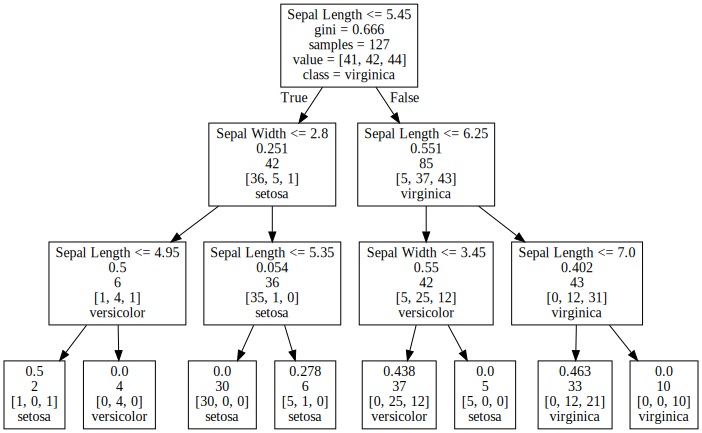

In [6]:
#importiamo alcuni package che ci permettono di visualizzare gli alberi
from sklearn import tree
import graphviz 

#specifichiamo, tra le altre cose, il nomi delle feature e quelli delle classi
#specifichiamo rotate=True per visualizzare l'albero in orizzontale
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=['Sepal Length','Sepal Width'],
                                class_names=dt.classes_, rotate=False, label='root') 
graph = graphviz.Source(dot_data)
graph

L'albero mostra l'insieme di regole apprese dal classificatore. In particolare, per ogni nodo sono mostrate:
 * La condizione di split (es. Sepal Length <=5.45);
 * L'indice di impurità di gini relativo al nodo (es. gini = 0.666);
 * Il numero di campioni che si trovano nello split (es. samples = 127);
 * Il numero di campioni classificati come appartenenti a ciascuna delle classi, in quel nodo (es. value=[41,42,44]);
 * La classe associata al nodo (es. class=virginica).

Un albero decisionale suddivide lo spazio di partenza in aree i cui bordi sono paralleli agli assi. Le linee di separazione tra le aree costituiscono il **decision boundary** del classificatore, analogamente a quanto visto per altri metodi. Proviamo a visualizzare il decision boundary appreso dal decision tree sullo spazio bidimensionale di partenza.

Scriviamo innanzitutto una funzione che ci permetta di visualizzare i dati come punti nello spazio 2D:

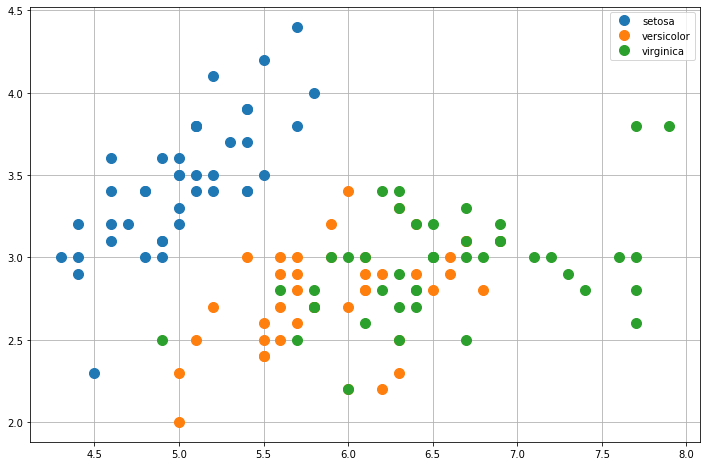

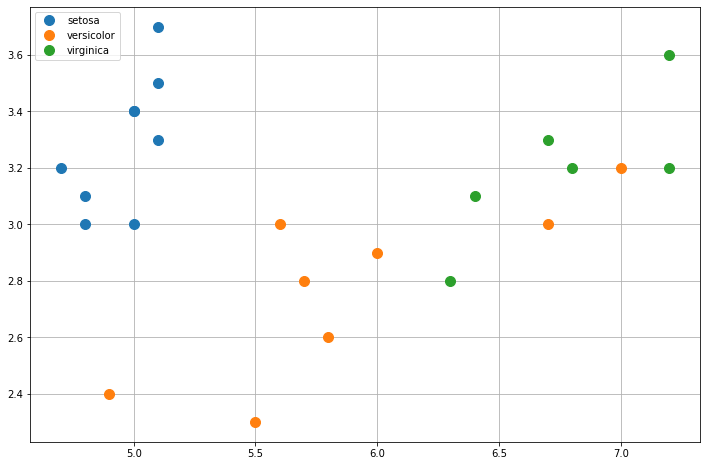

In [7]:
from matplotlib import pyplot as plt

def plot2d(data, marker='o'):
    classes = sorted(data.C.unique())
    for c in classes:
        plt.plot(data[data['C']==c].X.values,
                 data[data['C']==c].Y.values, '.', label=c, marker=marker, markersize=10)

plt.figure(figsize=(12,8))
plot2d(fisher_training2d)
plt.grid()
plt.legend()

plt.figure(figsize=(12,8))
plot2d(fisher_test2d)
plt.grid()
plt.legend()
plt.show()

Possiamo visualizzare il decision boundary generando una griglia uniforme di punti e lasciando che l'albero classifichi ciascuno di questi punti. Definiamo una funzione che ci permetta di farlo:

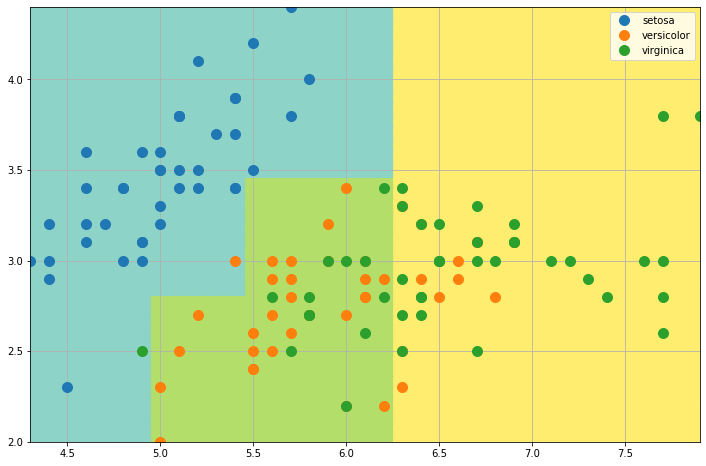

In [8]:
def plot_decision_tree_boundary(data, tree):
    #plottiamo i dati
    plot2d(data)
    #campioniamo 200 punti in maniera uniforme su entrambi gli assi
    X = np.linspace(data.X.min(), data.X.max(),200)
    Y = np.linspace(data.Y.min(), data.Y.max(),200)
    
    #costruiamo una griglia di coppie 2D di punti
    X,Y = np.meshgrid(X,Y)
    
    #classifichiamo tutti i punti
    Z = tree.predict(np.c_[X.ravel(), Y.ravel()]) # c_ concatena gli array lungo la seconda dimensione
    
    #recuperiamo i nomi delle classi e mettiamole in un dizionario
    class_dict = {c:i for i,c in enumerate(tree.classes_)}
    
    #trasformiamo gli id in classi
    Z=np.array(list(map(lambda x: class_dict[x],Z)))
    
    #modifichiamo la shape di Z per farla diventare una griglia   
    Z = np.array(Z).reshape(X.shape)
    
    #utiliziamo pcolormesh per visualizzare le aree
    plt.pcolormesh(X, Y, Z, antialiased=True, cmap='Set3')

plt.figure(figsize=(12,8))
plot_decision_tree_boundary(fisher_training2d,dt)
plt.grid()
plt.legend()
plt.show()

Il decision tree trovato è piuttosto semplice in quanto abbiamo specificato profondità massima $3$. Proviamo a riallenare il decision tree senza specificare una altezza massima:

In [9]:
dt = DecisionTreeClassifier()
dt.fit(fisher_training2d.drop('C',axis=1),fisher_training2d['C'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Visualizziamo la soluzione trovata:

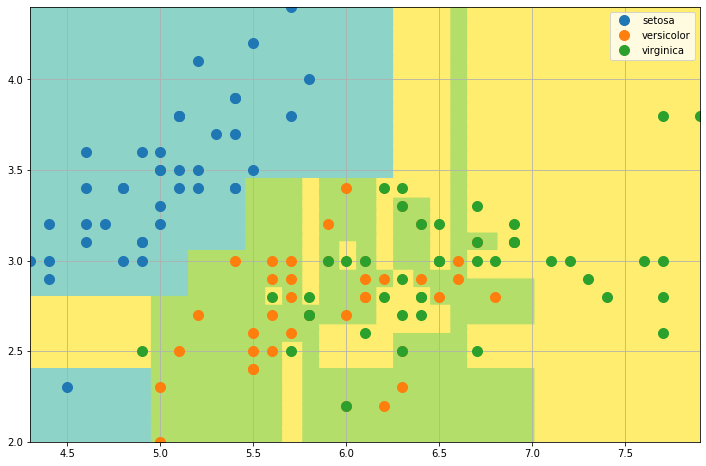

In [10]:
plt.figure(figsize=(12,8))
plot_decision_tree_boundary(fisher_training2d,dt)
plt.grid()
plt.legend()
plt.show()

# 15.2 Alberi Decisionali su più variabili

Vediamo adesso di allenare l'albero con tutte le variabili, imponendo profondità massima 3:

In [11]:
#limitiamo la profondità massima dell'albero per poterlo visualizzare in seguito
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(fisher_training.drop('Species',axis=1),fisher_training['Species'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Calcoliamo le performance sul test set:

In [12]:
dt.score(fisher_test.drop('Species',axis=1), fisher_test['Species'])

0.9565217391304348

Visualizziamo l'albero trovato:

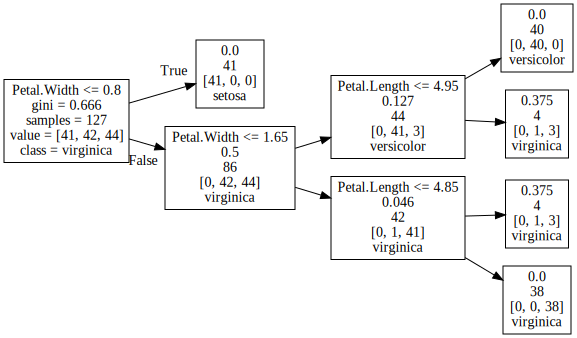

In [13]:
#specifichiamo, tra le altre cose, il nomi delle feature e quelli delle classi
#specifichiamo rotate=True per visualizzare l'albero in orizzontale
dot_data = tree.export_graphviz(dt, out_file=None,feature_names=fisher_training.columns[:-1],
                                class_names=dt.classes_,rotate=True, label='root') 
graph = graphviz.Source(dot_data)
graph

# 15.3 Foreste di Alberi "Random"

Le foreste di alberi casuali risolvono il problema di classificazione allenando molti alberi di profondità limitata ove le soglie per lo splitting sono scelte a caso. Proviamo ad allenare una foresta con $100$ alberi di profondità massima $3$:

In [14]:
from sklearn.ensemble import RandomForestClassifier
#le random forest sono dei metodi stocastici
#e dunque possono dare risultati diversi per run diversi
#impostiamo un seed per ripetitibilità
np.random.seed(1348)
#limitiamo la profondità massima dell'albero per poterlo visualizzare in seguito
df = RandomForestClassifier(max_depth=3, n_estimators=100)
df.fit(fisher_training2d.drop('C',axis=1),fisher_training2d['C'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Calcoliamo l'accuracy di training e di test:

In [15]:
print("Accuracy di training del modello: %0.2f" % df.score(fisher_training2d.drop('C',axis=1),fisher_training2d['C']))
print("Accuracy di test del modello: %0.2f" % df.score(fisher_test2d.drop('C',axis=1),fisher_test2d['C']))

Accuracy di training del modello: 0.83
Accuracy di test del modello: 0.91


Visualizziamo la soluzione trovata dalla foresta:

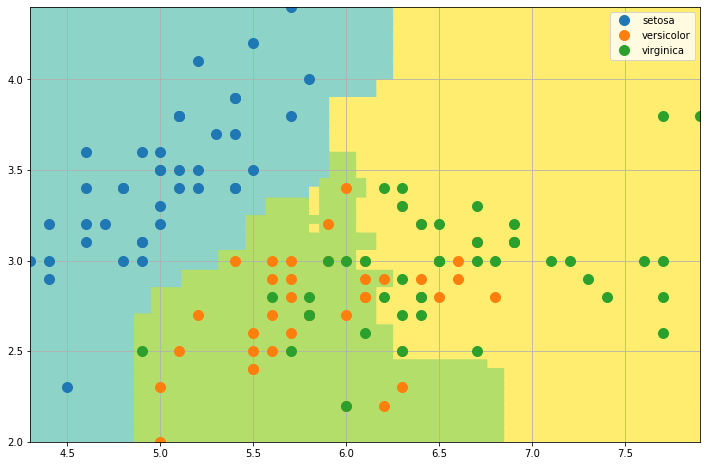

In [16]:
plt.figure(figsize=(12,8))
plot_decision_tree_boundary(fisher_training2d,df)
plt.grid()
plt.legend()
plt.show()

Proviamo un **GridSearchCV** su alcuni parametri della foresta:

In [17]:
from sklearn.model_selection import GridSearchCV
#impostiamo un seed per ripetitibilità
np.random.seed(1348)
#definiamo la griglia di parametri
param_grid = {'max_depth': [3, 10, 15, None], 'n_estimators': [50, 100, 150, 200]}
#definiamo l'oggetto Grid Search
gs = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, n_jobs=2, cv=5)
#avviamo la ricerca dei parametri ottimali sui nostri dati
gs.fit(fisher_training2d.drop('C',axis=1),fisher_training2d['C'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    6.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Visualizziamo i parametri ottimali:

In [18]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Calcoliamo l'accuracy di training e di test:

In [19]:
print("Accuracy di training del modello ottimizzato: %0.2f" % gs.score(fisher_training2d.drop('C',axis=1),fisher_training2d['C']))
print("Accuracy di test del modello ottimizzato: %0.2f" % gs.score(fisher_test2d.drop('C',axis=1),fisher_test2d['C']))

Accuracy di training del modello ottimizzato: 0.83
Accuracy di test del modello ottimizzato: 0.91


## - Decision Trees - Fine